# RBM as a Quantum Wave Function Ansatz

In [0]:
from __future__ import division
try:
    import torch
except:
    !pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
    import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

## Variational Monte Carlo
With RBM as a state ansatz, we need to train its parameters in order to make it have maximum overlap with the ground state wave function of a hamiltonian.

Notice that the cost function now is the energy rather than the log-likelihood with some known dataset:
$$E_\theta=\frac{\langle\psi_\theta|H|\psi_\theta\rangle}{\langle\psi_\theta|\psi_\theta\rangle}$$
Here, $\theta$ represents parameters in a RBM.

We use Variational Monte Carlo (VMC) method to get the energy expectation and gradients to optimize the ansatz.
VMC states that the gradient of $E$ with respect to $\theta$ is defined as 
$$g=\langle E_{\rm loc}\Delta_{\rm loc}\rangle- \langle E_{\rm loc}\rangle\langle\Delta_{\rm loc}\rangle$$
where $\langle\cdot\rangle$ is the ensemble average over Monte Carlo importance sampling $x\sim|\psi_\theta(x)|^2$, $E_{\rm loc}=\frac{\langle x|H|\psi_\theta\rangle}{\langle x|\psi_\theta\rangle}$, $\Delta_{\rm loc}\equiv\frac{\partial\log\psi_\theta(x)}{\partial \theta}$.

### VMC measurements
1. obtain some samples using `vim_sample` method.
2. perform measurements on samples.


VMC gives expectation values for $\langle E_{\rm loc}\rangle$, $\langle\Delta_{\rm loc}\rangle$ and $\langle E_{\rm loc}\Delta_{\rm loc}\rangle$.
It requires a kernel with following methods
* **propose_config**: propose a new configuration, given old configuration.
* **prob**: give probability for a spin configuration $\langle\sigma|\psi\rangle$.

In [0]:
def vmc_sample(kernel, initial_config, num_bath, num_sample):
    '''
    obtain a set of samples.

    Args:
        kernel (object): defines how to sample, requiring the following methods:
            * propose_config, propose a new configuration.
            * prob, get the probability of specific distribution.
        initial_config (1darray): initial configuration.
        num_bath (int): number of updates to thermalize.
        num_sample (int): number of samples.

    Return:
        list: a list of spin configurations.
    '''
    print_step = np.Inf  # steps between two print of accept rate, Inf to disable showing this information.

    config = initial_config
    prob = kernel.prob(config)

    n_accepted = 0
    sample_list = []
    for i in range(num_bath + num_sample):
        # generate new config and calculate probability ratio
        config_proposed = kernel.propose_config(config)
        prob_proposed = kernel.prob(config_proposed)

        # accept/reject a move by metropolis algorithm (world's most famous single line algorithm)
        if np.random.random() < prob_proposed / prob:
            config = config_proposed
            prob = prob_proposed
            n_accepted += 1

        # print statistics
        if i % print_step == print_step - 1:
            print('%-10s Accept rate: %.3f' %
                  (i + 1, n_accepted * 1. / print_step))
            n_accepted = 0

        # add a sample
        if i >= num_bath:
            sample_list.append(config_proposed)
    return sample_list


def vmc_measure(local_measure, sample_list, measure_step, num_bin=50):
    '''
    perform measurements on samples

    Args:
        local_measure (func): local measurements function, input configuration, return local energy and local gradient.
        sample_list (list): a list of spin configurations.
        num_bin (int): number of bins in binning statistics.
        meaure_step: number of samples skiped between two measurements + 1.

    Returns:
        tuple: expectation valued of energy, gradient, energy*gradient and error of energy.
    '''
    # measurements
    energy_loc_list, grad_loc_list = [], []
    for i, config in enumerate(sample_list):
        if i % measure_step == 0:
            # back-propagation is used to get gradients.
            energy_loc, grad_loc = local_measure(config)
            energy_loc_list.append(energy_loc)
            grad_loc_list.append(grad_loc)

    # binning statistics for energy
    energy_loc_list = np.array(energy_loc_list)
    energy, energy_precision = binning_statistics(energy_loc_list, num_bin=num_bin)

    # get expectation values
    energy_loc_list = torch.from_numpy(energy_loc_list)
    if grad_loc_list[0][0].is_cuda: energy_loc_list = energy_loc_list.cuda()
    grad_mean = []
    energy_grad = []
    for grad_loc in zip(*grad_loc_list):
        grad_loc = torch.stack(grad_loc, 0)
        grad_mean.append(grad_loc.mean(0))
        energy_grad.append(
            (energy_loc_list[(slice(None),) + (None,) * (grad_loc.dim() - 1)] * grad_loc).mean(0))
    return energy.item(), grad_mean, energy_grad, energy_precision



def binning_statistics(var_list, num_bin):
    '''
    binning statistics for variable list.
    '''
    num_sample = len(var_list)
    if num_sample % num_bin != 0:
        raise
    size_bin = num_sample // num_bin

    # mean, variance
    mean = np.mean(var_list, axis=0)
    variance = np.var(var_list, axis=0)

    # binned variance and autocorrelation time.
    variance_binned = np.var(
        [np.mean(var_list[size_bin * i:size_bin * (i + 1)]) for i in range(num_bin)])
    t_auto = 0.5 * size_bin * \
        np.abs(np.mean(variance_binned) / np.mean(variance))
    stderr = np.sqrt(variance_binned / num_bin)
    print('Binning Statistics: Energy = %.4f +- %.4f, Auto correlation Time = %.4f' %
          (mean, stderr, t_auto))
    return mean, stderr

### VMC Kernel definition
When proposing a new configuration, it has 5% probability to flip all spin, can making VMC sample better in Heisenberg model, proposed configuration satisfies spin conservation.


In [0]:
class VMCKernel(object):
    '''
    variational monte carlo kernel.

    Attributes:
        energy_loc (func): local energy <x|H|\psi>/<x|\psi>.
        ansatz (Module): torch neural network.
    '''
    def __init__(self, energy_loc, ansatz):
        self.ansatz = ansatz
        self.energy_loc = energy_loc

    def prob(self, config):
        '''
        probability of configuration.

        Args:
            config (1darray): the bit string as a configuration.

        Returns:
            number: probability |<config|psi>|^2.
        '''
        return abs(self.ansatz.psi(torch.from_numpy(config)).data[0])**2

    def local_measure(self, config):
        '''
        get local quantities energy_loc, grad_loc.

        Args:
            config (1darray): the bit string as a configuration.

        Returns:
            number, list: local energy and local gradients for variables.
        '''
        psi_loc = self.ansatz.psi(torch.from_numpy(config))

        # get gradients {d/dW}_{loc}
        self.ansatz.zero_grad()
        psi_loc.backward()
        grad_loc = [p.grad.data/psi_loc.data[0] for p in self.ansatz.parameters()]

        # E_{loc}
        eloc = self.energy_loc(config, lambda x: self.ansatz.psi(torch.from_numpy(x)).data, psi_loc.data)[0]
        return eloc, grad_loc

    @staticmethod
    def propose_config(old_config, prob_flip=0.05):
        '''
        flip two positions as suggested spin flips.

        Args:
            old_config (1darray): spin configuration, which is a [-1,1] string.
            prob_flip (float): the probability to flip all spins, to make VMC more statble in Heisenberg model.

        Returns:
            1darray: new spin configuration.
        '''
        # take ~ 5% probability to flip all spin, can making VMC sample better in Heisenberg model
        if np.random.random() < prob_flip:
            return -old_config

        num_spin = len(old_config)
        upmask = old_config == 1
        flips = np.random.randint(0, num_spin // 2, 2)
        iflip0 = np.where(upmask)[0][flips[0]]
        iflip1 = np.where(~upmask)[0][flips[1]]

        config = old_config.copy()
        config[iflip0] = -1
        config[iflip1] = 1
        return config

## Wave function ansatz
Comparing with the model defined in last example, we make serveral adaptions here
* using {-1, 1} valued nodes instead of {0, 1} valued nodes.
* use probability function of visual nodes directly, $p(v)\sim e^{x^T a}\prod\limits_i2\cosh(W_ix+b_i)$.

In [0]:
class RBM(nn.Module):
    '''
    Restricted Boltzmann Machine

    Args:
        num_visible (int): number of visible nodes.
        num_hidden (int): number of hidden nodes.

    Attributes:
        W (2darray): weights.
        v_bias (1darray): bias for visible layer.
        h_bias (1darray): bias for hidden layer.
    '''

    def __init__(self, num_visible, num_hidden):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(num_hidden, num_visible).double() * 1e-1)
        self.v_bias = nn.Parameter(torch.zeros(num_visible).double())
        self.h_bias = nn.Parameter(torch.randn(num_hidden).double() * 1e-1)
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        
    def psi(self, v):
        '''
        probability for visible nodes, visible/hidden nodes here take value in {-1, 1}.

        Args:
            v (1darray): visible input.

        Return:
            float: the probability of v.
        '''
        v = Variable(v.double())
        if self.W.is_cuda: v = v.cuda()
        res = (2 * (self.W.mv(v) + self.h_bias).cosh()).prod() * (self.v_bias.dot(v)).exp()
        return res

## Hamiltonian
Here, we use the Heisenberg model with rotated basis
$$H=\sum\limits_i J_z S_i^zS_{i+1}^z-\frac{J_{xy}}{2}(S^+_{i}S^-_{i+1}+S^-_{i}S^+_{i+1})$$
Comparing with traditional Heisenberg model, we performed transformation $S^{x,y}_i=-S^{x,y}_i,i\in \rm odd$, intended to make the ground state wave function always positive.

Instead of defining the hamiltonian directlt, we define a function to calculate $E_{\rm loc}$

In [0]:
def heisenberg_loc(config, psi_func, psi_loc, J=1.):
    '''
    local energy for 1D Periodic Heisenberg chain.

    Args:
        config (1darray): bit string as spin configuration.
        psi_func (func): wave function.
        psi_loc (number): wave function projected on configuration <config|psi>.
        J (float): coupling strengh. Here, J = Jxy = Jz.

    Returns:
        number: local energy.
    '''
    # get weights and flips after applying hamiltonian \sum_i w_i|x_i> = H|x>
    nsite = len(config)
    wl, flips = [], []
    # J*SzSz terms.
    nn_par = np.roll(config, -1) * config
    wl.append(J / 4. * (nn_par).sum(axis=-1).item())
    flips.append(np.array([], dtype='int64'))

    # J*SxSx and J*SySy terms.
    mask = nn_par != 1
    i = np.where(mask)[0]
    j = (i + 1) % nsite
    wl += [-J / 2.] * len(i)
    flips.extend(zip(i, j))

    # calculate local energy <\psi|H|x>/<\psi|x>
    acc = 0.
    for wi, flip in zip(wl, flips):
        config_i = config.copy()
        config_i[list(flip)] *= -1
        eng_i = wi * (psi_func(config_i) / psi_loc)
        acc += eng_i
    return acc

## The training

In [0]:
def train(model, learning_rate, use_cuda):
    '''
    train a model.

    Args:
        model (obj): a model that meet VMC model definition.
        learning_rate (float): the learning rate for SGD.
    '''
    initial_config = np.array([-1, 1] * (model.ansatz.num_visible // 2))
    if use_cuda:
        model.ansatz.cuda()

    while True:
        # get expectation values for energy, gradient and their product,
        # as well as the precision of energy.        
        sample_list = vmc_sample(model, initial_config, num_bath=200, num_sample=8000)
        energy, grad, energy_grad, precision = vmc_measure(model.local_measure, sample_list, num_spin)

        # update variables using steepest gradient descent
        g_list = [eg - energy * g for eg, g in zip(energy_grad, grad)]
        for var, g in zip(model.ansatz.parameters(), g_list):
            delta = learning_rate * g
            var.data -= delta
        yield energy, precision

### Start training
We will see GPU is not better than CPU in this case. There are mainly two factors causing this
* the scale of vectorized operation is not large enough
* freqent data transfer between CPU and GPU can become a bottleneck.

Binning Statistics: Energy = -2.6167 +- 0.0396, Auto correlation Time = 0.3829
Step 0, dE/|E| = 0.2833, elapse = 2.8448
Binning Statistics: Energy = -2.6833 +- 0.0418, Auto correlation Time = 0.4617
Step 1, dE/|E| = 0.2651, elapse = 2.8340
Binning Statistics: Energy = -2.7252 +- 0.0433, Auto correlation Time = 0.5240
Step 2, dE/|E| = 0.2536, elapse = 2.8353
Binning Statistics: Energy = -2.7277 +- 0.0375, Auto correlation Time = 0.4249
Step 3, dE/|E| = 0.2529, elapse = 2.8072
Binning Statistics: Energy = -2.7046 +- 0.0397, Auto correlation Time = 0.5204
Step 4, dE/|E| = 0.2592, elapse = 2.8732
Binning Statistics: Energy = -2.8293 +- 0.0368, Auto correlation Time = 0.4797
Step 5, dE/|E| = 0.2251, elapse = 2.8081
Binning Statistics: Energy = -2.7342 +- 0.0301, Auto correlation Time = 0.3630
Step 6, dE/|E| = 0.2511, elapse = 2.7720
Binning Statistics: Energy = -2.8613 +- 0.0329, Auto correlation Time = 0.4558
Step 7, dE/|E| = 0.2163, elapse = 2.8127
Binning Statistics: Energy = -2.8516 +- 

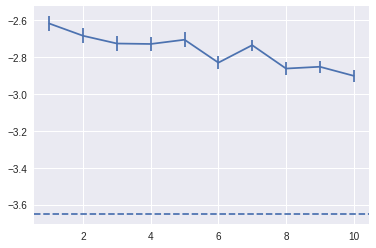

Binning Statistics: Energy = -2.8981 +- 0.0334, Auto correlation Time = 0.5229
Step 10, dE/|E| = 0.2062, elapse = 2.8595
Binning Statistics: Energy = -2.9901 +- 0.0311, Auto correlation Time = 0.5163
Step 11, dE/|E| = 0.1810, elapse = 2.8079
Binning Statistics: Energy = -2.9916 +- 0.0327, Auto correlation Time = 0.5530
Step 12, dE/|E| = 0.1806, elapse = 2.7827
Binning Statistics: Energy = -3.0688 +- 0.0292, Auto correlation Time = 0.4507
Step 13, dE/|E| = 0.1595, elapse = 2.8717
Binning Statistics: Energy = -3.0617 +- 0.0305, Auto correlation Time = 0.4860
Step 14, dE/|E| = 0.1614, elapse = 2.8932
Binning Statistics: Energy = -3.0865 +- 0.0300, Auto correlation Time = 0.5204
Step 15, dE/|E| = 0.1546, elapse = 2.9882
Binning Statistics: Energy = -3.0861 +- 0.0224, Auto correlation Time = 0.3123
Step 16, dE/|E| = 0.1548, elapse = 2.9153
Binning Statistics: Energy = -3.1325 +- 0.0305, Auto correlation Time = 0.5217
Step 17, dE/|E| = 0.1420, elapse = 2.7924
Binning Statistics: Energy = -3.

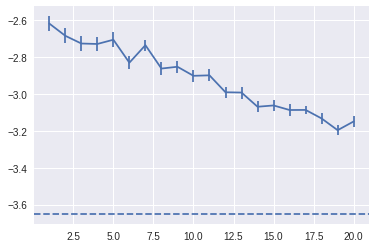

Binning Statistics: Energy = -3.1554 +- 0.0276, Auto correlation Time = 0.5032
Step 20, dE/|E| = 0.1358, elapse = 2.8457
Binning Statistics: Energy = -3.1462 +- 0.0266, Auto correlation Time = 0.4761
Step 21, dE/|E| = 0.1383, elapse = 2.8086
Binning Statistics: Energy = -3.1772 +- 0.0265, Auto correlation Time = 0.4905
Step 22, dE/|E| = 0.1298, elapse = 2.8141
Binning Statistics: Energy = -3.2392 +- 0.0217, Auto correlation Time = 0.3117
Step 23, dE/|E| = 0.1128, elapse = 2.7909
Binning Statistics: Energy = -3.2329 +- 0.0267, Auto correlation Time = 0.5480
Step 24, dE/|E| = 0.1145, elapse = 2.8038
Binning Statistics: Energy = -3.2292 +- 0.0227, Auto correlation Time = 0.4536
Step 25, dE/|E| = 0.1156, elapse = 2.7819
Binning Statistics: Energy = -3.2650 +- 0.0209, Auto correlation Time = 0.3943
Step 26, dE/|E| = 0.1058, elapse = 2.8489
Binning Statistics: Energy = -3.2713 +- 0.0250, Auto correlation Time = 0.6313
Step 27, dE/|E| = 0.1040, elapse = 2.8213
Binning Statistics: Energy = -3.

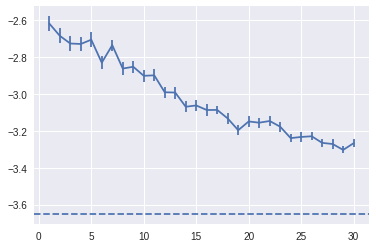

Binning Statistics: Energy = -3.2723 +- 0.0224, Auto correlation Time = 0.5670
Step 30, dE/|E| = 0.1037, elapse = 2.8492
Binning Statistics: Energy = -3.3132 +- 0.0202, Auto correlation Time = 0.5288
Step 31, dE/|E| = 0.0925, elapse = 2.7969
Binning Statistics: Energy = -3.3094 +- 0.0203, Auto correlation Time = 0.6100
Step 32, dE/|E| = 0.0936, elapse = 2.7456
Binning Statistics: Energy = -3.2999 +- 0.0194, Auto correlation Time = 0.6291
Step 33, dE/|E| = 0.0962, elapse = 2.7862
Binning Statistics: Energy = -3.3216 +- 0.0161, Auto correlation Time = 0.4356
Step 34, dE/|E| = 0.0902, elapse = 2.7511
Binning Statistics: Energy = -3.3375 +- 0.0189, Auto correlation Time = 0.7100
Step 35, dE/|E| = 0.0859, elapse = 2.7937
Binning Statistics: Energy = -3.3523 +- 0.0120, Auto correlation Time = 0.3221
Step 36, dE/|E| = 0.0818, elapse = 2.7741
Binning Statistics: Energy = -3.3598 +- 0.0144, Auto correlation Time = 0.4669
Step 37, dE/|E| = 0.0798, elapse = 2.7876
Binning Statistics: Energy = -3.

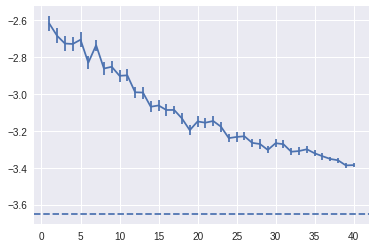

Binning Statistics: Energy = -3.4041 +- 0.0122, Auto correlation Time = 0.4317
Step 40, dE/|E| = 0.0677, elapse = 2.8311
Binning Statistics: Energy = -3.4153 +- 0.0125, Auto correlation Time = 0.4948
Step 41, dE/|E| = 0.0646, elapse = 2.7729
Binning Statistics: Energy = -3.4582 +- 0.0110, Auto correlation Time = 0.3939
Step 42, dE/|E| = 0.0528, elapse = 2.8065
Binning Statistics: Energy = -3.4080 +- 0.0097, Auto correlation Time = 0.3460
Step 43, dE/|E| = 0.0666, elapse = 2.7714
Binning Statistics: Energy = -3.4292 +- 0.0105, Auto correlation Time = 0.4567
Step 44, dE/|E| = 0.0608, elapse = 2.8522
Binning Statistics: Energy = -3.4712 +- 0.0110, Auto correlation Time = 0.5589
Step 45, dE/|E| = 0.0493, elapse = 2.8067
Binning Statistics: Energy = -3.4564 +- 0.0111, Auto correlation Time = 0.5253
Step 46, dE/|E| = 0.0533, elapse = 2.7988
Binning Statistics: Energy = -3.4727 +- 0.0121, Auto correlation Time = 0.6567
Step 47, dE/|E| = 0.0489, elapse = 2.7679
Binning Statistics: Energy = -3.

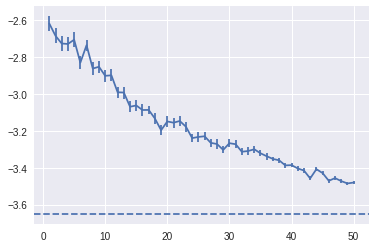

Binning Statistics: Energy = -3.4937 +- 0.0086, Auto correlation Time = 0.4338
Step 50, dE/|E| = 0.0431, elapse = 2.8324
Binning Statistics: Energy = -3.4831 +- 0.0093, Auto correlation Time = 0.5811
Step 51, dE/|E| = 0.0460, elapse = 2.7985
Binning Statistics: Energy = -3.5084 +- 0.0101, Auto correlation Time = 0.7029
Step 52, dE/|E| = 0.0391, elapse = 2.7828
Binning Statistics: Energy = -3.5069 +- 0.0076, Auto correlation Time = 0.4186
Step 53, dE/|E| = 0.0395, elapse = 2.7953
Binning Statistics: Energy = -3.5131 +- 0.0083, Auto correlation Time = 0.5033
Step 54, dE/|E| = 0.0378, elapse = 2.7955
Binning Statistics: Energy = -3.5129 +- 0.0075, Auto correlation Time = 0.4117
Step 55, dE/|E| = 0.0379, elapse = 2.8099
Binning Statistics: Energy = -3.5149 +- 0.0072, Auto correlation Time = 0.3751
Step 56, dE/|E| = 0.0373, elapse = 2.8286
Binning Statistics: Energy = -3.5244 +- 0.0081, Auto correlation Time = 0.4912
Step 57, dE/|E| = 0.0347, elapse = 2.8197
Binning Statistics: Energy = -3.

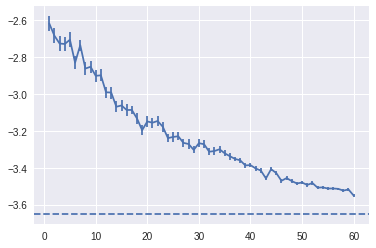

Binning Statistics: Energy = -3.5457 +- 0.0093, Auto correlation Time = 0.6373
Step 60, dE/|E| = 0.0289, elapse = 2.8398
Binning Statistics: Energy = -3.5364 +- 0.0085, Auto correlation Time = 0.5706
Step 61, dE/|E| = 0.0314, elapse = 2.8157
Binning Statistics: Energy = -3.5486 +- 0.0072, Auto correlation Time = 0.4360
Step 62, dE/|E| = 0.0281, elapse = 2.7567
Binning Statistics: Energy = -3.5568 +- 0.0081, Auto correlation Time = 0.6049
Step 63, dE/|E| = 0.0258, elapse = 2.8098
Binning Statistics: Energy = -3.5520 +- 0.0088, Auto correlation Time = 0.6357
Step 64, dE/|E| = 0.0271, elapse = 2.7626
Binning Statistics: Energy = -3.5701 +- 0.0071, Auto correlation Time = 0.4511
Step 65, dE/|E| = 0.0222, elapse = 2.7891
Binning Statistics: Energy = -3.5701 +- 0.0063, Auto correlation Time = 0.3931
Step 66, dE/|E| = 0.0222, elapse = 2.7796
Binning Statistics: Energy = -3.5587 +- 0.0077, Auto correlation Time = 0.5952
Step 67, dE/|E| = 0.0253, elapse = 2.8694
Binning Statistics: Energy = -3.

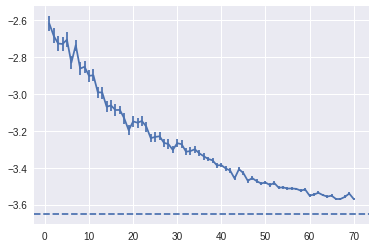

Binning Statistics: Energy = -3.5785 +- 0.0060, Auto correlation Time = 0.3262
Step 70, dE/|E| = 0.0199, elapse = 2.8962
Binning Statistics: Energy = -3.5637 +- 0.0065, Auto correlation Time = 0.4404
Step 71, dE/|E| = 0.0239, elapse = 2.7670
Binning Statistics: Energy = -3.5708 +- 0.0066, Auto correlation Time = 0.4262
Step 72, dE/|E| = 0.0220, elapse = 2.8009
Binning Statistics: Energy = -3.5692 +- 0.0070, Auto correlation Time = 0.4973
Step 73, dE/|E| = 0.0224, elapse = 2.8023
Binning Statistics: Energy = -3.5715 +- 0.0057, Auto correlation Time = 0.3298
Step 74, dE/|E| = 0.0218, elapse = 2.7596
Binning Statistics: Energy = -3.5823 +- 0.0068, Auto correlation Time = 0.4971
Step 75, dE/|E| = 0.0188, elapse = 2.7823
Binning Statistics: Energy = -3.5722 +- 0.0062, Auto correlation Time = 0.4373
Step 76, dE/|E| = 0.0216, elapse = 2.8110
Binning Statistics: Energy = -3.5715 +- 0.0065, Auto correlation Time = 0.4597
Step 77, dE/|E| = 0.0218, elapse = 2.7847
Binning Statistics: Energy = -3.

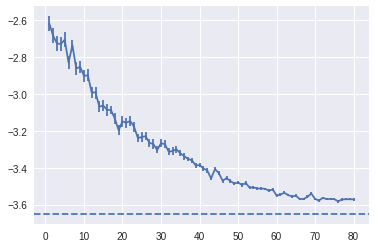

Binning Statistics: Energy = -3.5817 +- 0.0065, Auto correlation Time = 0.4754
Step 80, dE/|E| = 0.0190, elapse = 2.8283
Binning Statistics: Energy = -3.5747 +- 0.0066, Auto correlation Time = 0.5097
Step 81, dE/|E| = 0.0209, elapse = 2.8052
Binning Statistics: Energy = -3.5716 +- 0.0064, Auto correlation Time = 0.4711
Step 82, dE/|E| = 0.0218, elapse = 2.8108
Binning Statistics: Energy = -3.5701 +- 0.0056, Auto correlation Time = 0.3502
Step 83, dE/|E| = 0.0222, elapse = 2.8385
Binning Statistics: Energy = -3.5734 +- 0.0080, Auto correlation Time = 0.7040
Step 84, dE/|E| = 0.0213, elapse = 2.8412
Binning Statistics: Energy = -3.5823 +- 0.0052, Auto correlation Time = 0.3083
Step 85, dE/|E| = 0.0188, elapse = 2.8195
Binning Statistics: Energy = -3.5803 +- 0.0066, Auto correlation Time = 0.4907
Step 86, dE/|E| = 0.0194, elapse = 2.8092
Binning Statistics: Energy = -3.5722 +- 0.0069, Auto correlation Time = 0.5179
Step 87, dE/|E| = 0.0216, elapse = 2.8135
Binning Statistics: Energy = -3.

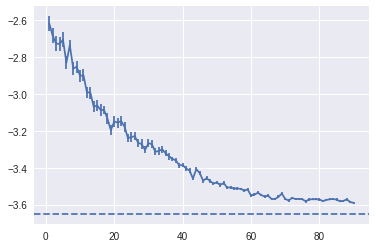

Binning Statistics: Energy = -3.5947 +- 0.0068, Auto correlation Time = 0.5059
Step 90, dE/|E| = 0.0154, elapse = 2.8311
Binning Statistics: Energy = -3.5923 +- 0.0066, Auto correlation Time = 0.5247
Step 91, dE/|E| = 0.0161, elapse = 2.8066
Binning Statistics: Energy = -3.5914 +- 0.0061, Auto correlation Time = 0.4312
Step 92, dE/|E| = 0.0164, elapse = 2.8158
Binning Statistics: Energy = -3.5816 +- 0.0077, Auto correlation Time = 0.6494
Step 93, dE/|E| = 0.0190, elapse = 2.9245
Binning Statistics: Energy = -3.5804 +- 0.0064, Auto correlation Time = 0.4793
Step 94, dE/|E| = 0.0194, elapse = 2.9332
Binning Statistics: Energy = -3.5748 +- 0.0068, Auto correlation Time = 0.5787
Step 95, dE/|E| = 0.0209, elapse = 3.0115
Binning Statistics: Energy = -3.5790 +- 0.0054, Auto correlation Time = 0.3881
Step 96, dE/|E| = 0.0198, elapse = 2.8956
Binning Statistics: Energy = -3.5905 +- 0.0064, Auto correlation Time = 0.4906
Step 97, dE/|E| = 0.0166, elapse = 2.8466
Binning Statistics: Energy = -3.

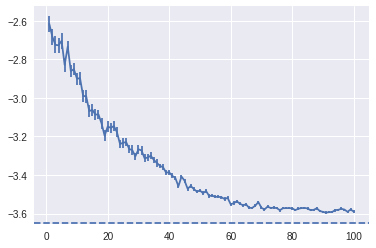

Binning Statistics: Energy = -3.5966 +- 0.0069, Auto correlation Time = 0.6739
Step 100, dE/|E| = 0.0149, elapse = 2.9056


In [32]:
%matplotlib inline
import time
import matplotlib.pyplot as plt

# set random number seed
use_cuda = False
seed = 10086
torch.manual_seed(seed)
if use_cuda: torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
max_iter = 100
num_spin = 8
num_hidden = 16
E_exact = -3.65109341

# visualize the loss history
energy_list, precision_list = [], []
def _update_curve(energy, precision):
    energy_list.append(energy)
    precision_list.append(precision)
    if len(energy_list)%10 == 0:
        plt.errorbar(np.arange(1, len(energy_list) + 1), energy_list, yerr=precision_list, capsize=3)
        # dashed line for exact energy
        plt.axhline(E_exact, ls='--')
        plt.show()

rbm = RBM(num_spin, num_hidden)
model = VMCKernel(heisenberg_loc, ansatz=rbm)

t0 = time.time()
for i, (energy, precision) in enumerate(train(model, learning_rate = 0.1, use_cuda = use_cuda)):
    t1 = time.time()
    print('Step %d, dE/|E| = %.4f, elapse = %.4f' % (i, -(energy - E_exact)/E_exact, t1-t0))
    _update_curve(energy, precision)
    t0 = time.time()

    # stop condition
    if i >= max_iter:
        break

## Challenge
J1-J2 model is an advanced version of Heisenberg model that takes 2nd nearest neighbor coupling terms into considerations. Its hamiltonian is 

$$H=J_1\sum\limits_i \vec S_i\cdot \vec S_{i+1}+ J_2\sum_i\vec S_i\cdot \vec S_{i+2}$$

The sign of its ground state wave functions $\psi(x)=\langle x|\psi\rangle$ can be either positive or negative. Since real valued RBM is not able to describe such a state.

With the following local energy function, write your own ansatz to obtain its ground state.

As a start point, you can try with 20 sites, $J_2=0.2$.
Obtain the best precision as you can.

Below is a table of DMRG results for benchmark, which is believe to be "exact" for 1D systems.

| &nbsp;&nbsp;&nbsp;$J_2$ &nbsp;&nbsp;&nbsp;  | 20             | 30             | 40             | 100            |
| -------------------- | -------------- | -------------- | -------------- | -------------- |
| 0.                   | -8.90438652988&nbsp;&nbsp;&nbsp; | -13.3219630586&nbsp;&nbsp;&nbsp; | -17.7465227719&nbsp;&nbsp;&nbsp; | -44.3229467082&nbsp;&nbsp;&nbsp; |
| 0.2                  | -8.20291625218 | -12.2770471706 | -16.3566615295 | -40.8572924302 |
| 0.5                  | -7.5           | -11.25         | -15            | 37.5           |
| 0.8                  | -8.46127240196 | -12.6588455544 | -16.8706800952 | -42.0700632095 |


In [0]:
def J1J2_loc(config, psi_func, psi_loc, J1, J1z, J2, J2z, periodic):
    '''
    local energy for 1D J1, J2 chain.

    Args:
        config (1darray): bit string as spin configuration.
        psi_func (func): wave function.
        psi_loc (number): wave function projected on configuration <config|psi>.
        J1, J1z, J2, J2z (float): coupling strenghs for nearest neightbor, nearest neighbor z-direction, 2nd nearest neighbor and 2nd nearest neighbor in z-direction.
        periodic (bool): boundary condition.

    Returns:
        number: local energy.
    '''
    nsite = len(config)
    wl, flips = [], []
    Js = [J1, J2]
    Jzs = [J1z, J2z]
    for INB, (J,Jz) in enumerate(zip(Js, Jzs)):
        # J1(SzSz) terms.
        nn_par = np.roll(config, -INB-1) * config
        if not periodic:
            nn_par = nn_par[:-INB-1]
        wl.append(Jz / 4. * (nn_par).sum(axis=-1))
        flips.append(np.array([], dtype='int64'))

        # J1(SxSx) and J1(SySy) terms.
        mask = nn_par != 1
        i = np.where(mask)[0]
        j = (i + INB+1) % nsite

        wl += [J / 2.] * len(i)
        flips.extend(zip(i, j))
        
    # calculate local energy <\psi|H|x>/<\psi|x>
    acc = 0
    for wi, flip in zip(wl, flips):
        config_i = config.copy()
        config_i[list(flip)] *= -1
        eng_i = wi * psi_func(config_i) / psi_loc
        acc += eng_i
    return acc

## Hints
* spliting phase and amplitude parts of a wave function is suggested in

    `Cai, Zi, and Jinguo Liu. "Approximating quantum many-body wave functions using artificial neural networks." Physical Review B 97.3 (2018): 035116.`
* using **symmetries** like invariance under translation ,spin flip and inversion in your model to make training more stable.
Ground states of J1-J2 models with different $J_2$ or $N$ lies in different symmetry blocks.
* use stochastic reconfiguration or Adam as a better **optimization** method.
* rewrite the part of code to get local energy using C/C++/Fortran for speed up.
* use tensorflow or your own modules to support **complex values**.
* for large scale 2D J1-J2 model, its ground state is an **open question yet**!